In [3]:
%pip install matplotlib

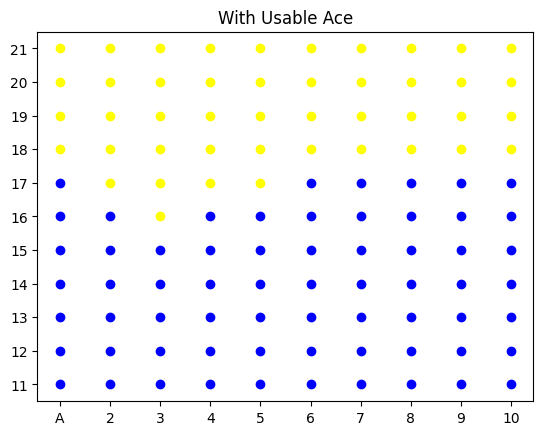

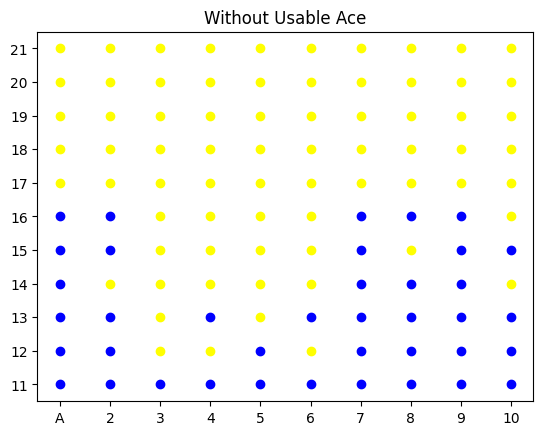

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class Player(object):
    def __init__(self, currentSum, usableAce, dealersCard):
#플레이어의 카드합,에이스 여부,딜러의 카드 저장
        self.currentSum = currentSum
        self.dealersCard = dealersCard
        self.usableAce = usableAce
        self.usingAce = self.usableAce

    def ReceiveCard(self, card):
#카드를 받았을때,에이스가 사용가능하고 합이 21이넘는 다면 1로 사용
        if self.usingAce and self.currentSum + card > 21:
            self.usingAce = False
            self.currentSum += card - 10
        else:
            self.currentSum += card
#현재 카드 상태 반환
    def GetState(self):
        return (self.currentSum, self.usableAce, self.dealersCard)
#현재 카드 합 반환
    def GetValue(self):
        return self.currentSum
#hit결정
    def ShouldHit(self, policy):
        return policy[self.GetState()]
#파산 여부 결정
    def Bust(self):
        return self.GetValue() > 21

class Dealer(object):
#딜러의 카드 리스트 반환
    def __init__(self, cards):
        self.cards = cards
#카드를 받을 때 리스트에 추가
    def ReceiveCard(self, card):
        self.cards.append(card)
#카드의 합계산
    def GetValue(self):
        currentSum = 0
        aceCount = 0

        for card in self.cards:
            if card == 1:
                aceCount += 1
            else:
                currentSum += card

        while aceCount > 0:
            aceCount -= 1
            currentSum += 11

            if currentSum > 21:
                aceCount += 1
                currentSum -= 11
                currentSum += aceCount
                break

        return currentSum
#딜러가 17미만이면 hit,아니면 stay
    def ShouldHit(self):
        if self.GetValue() >= 17:
            return False
        else:
            return True
#카드합에 따라bust 여부
    def Bust(self):
        return self.GetValue() > 21
#상태-행동 쌍 배열과 중복 방지용 set
class StateActionInfo(object):
    def __init__(self):
        self.stateActionPairs = [ ]
        self.stateActionMap = set()
#중복된 pair 추가하지않게
    def AddPair(self, pair):
        if pair in self.stateActionMap:
            return

        self.stateActionPairs.append(pair)
        self.stateActionMap.add(pair)
#반환값 누적및 Q값 업데이트
def EvaluateAndImprovePolicy(qMap, policy, returns, stateActionPairs, reward):
    for pair in stateActionPairs:
        returns[pair] += 1
        qMap[pair] = qMap[pair] + ((reward - qMap[pair]) / returns[pair])
#정책 개선:Q값이 더 높은 행동 선택
        state = pair[0]
        shouldHit = False

        if qMap[(state, True)] > qMap[(state, False)]:
            shouldHit = True

        policy[state] = shouldHit

def newCard():
    #1-13정수 생성,10이상은 모두 10처리
    card = np.random.randint(1, 14)

    if card > 9:
        return 10
    else:
        return card
#플레이어와 딜러의 초기상태 랜덤 생성
def PlayEpisode(qMap, policy, returns):
    playerSum = np.random.randint(11, 22)
    dealerOpenCard = np.random.randint(1, 11)
    usableAce = bool(np.random.randint(0, 2))

    player = Player(playerSum, usableAce, dealerOpenCard)
    dealer = Dealer([dealerOpenCard])

    stateActionInfo = StateActionInfo()
    hitAction = bool(np.random.randint(0, 2))
    stateActionInfo.AddPair((player.GetState(), hitAction))
#최초 행동후,플레이어 정책에 따라 hit/stay 반복
    if hitAction:
        player.ReceiveCard(newCard())

        while not player.Bust() and player.ShouldHit(policy):
            stateActionInfo.AddPair((player.GetState(), True))
            player.ReceiveCard(newCard())
#플레이어 bust시 -1보상
    if player.Bust():
        EvaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, -1)
        return

    stateActionInfo.AddPair((player.GetState(), False))
    dealer.ReceiveCard(newCard())

    while not dealer.Bust() and dealer.ShouldHit():
        dealer.cards.append(newCard())
#승패 계산 및 정책 평가
    if dealer.Bust() or dealer.GetValue() < player.GetValue():
        EvaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, 1)
    elif dealer.GetValue() > player.GetValue():
        EvaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, -1)
    else:
        EvaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, 0)


qMap = { }
policy = { }
returns = { }
#모든 가능한 상태에 대해 Q값,반환값,정책 초기화
for playerSum in range(11, 22):
    for usableAce in range(2):
        for dealersCard in range(1, 11):
            playerState = (playerSum, bool(usableAce), dealersCard)
            qMap[(playerState, False)] = 0
            qMap[(playerState, True)] = 0
            returns[(playerState, False)] = 0
            returns[(playerState, True)] = 0
#카드합이 20,21인경우 stay 아닌경우 hit로 초기화
            if playerSum == 20 or playerSum == 21:
                policy[playerState] = False
            else:
                policy[playerState] = True
#게임 실해하며 업데이트
for i in range(100000):
    PlayEpisode(qMap, policy, returns)
#데이터 시각화 준비
x11 = [ ]
y11 = [ ]

x12 = [ ]
y12 = [ ]

x21 = [ ]
y21 = [ ]

x22 = [ ]
y22 = [ ]

for playerState in policy:
    if playerState[1]:
        if policy[playerState]:
            x11.append(playerState[2] - 1)
            y11.append(playerState[0] - 11)
        else:
            x12.append(playerState[2] - 1)
            y12.append(playerState[0] - 11)
    else:
        if policy[playerState]:
            x21.append(playerState[2] - 1)
            y21.append(playerState[0] - 11)
        else:
            x22.append(playerState[2] - 1)
            y22.append(playerState[0] - 11)

plt.figure(0)
plt.title('With Usable Ace')
plt.scatter(x11, y11, color='blue')
plt.scatter(x12, y12, color='yellow')
plt.xticks(range(10), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
plt.yticks(range(11), [ '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

plt.figure(1)
plt.title('Without Usable Ace')
plt.scatter(x21, y21, color='blue')
plt.scatter(x22, y22, color='yellow')
plt.xticks(range(10), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
plt.yticks(range(11), [ '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

plt.show()